# Model training

In this file, I want to build and train some models and select the best predictor of ace/no ace.

## Importing libraries

In [1]:
# Import everything from my_libraries.py
from my_libraries import *  # noqa: F403

# Other utilities
import tennis_utils
import dataframe_utils

In [2]:
# Read into dataframe
df = pd.read_csv("datasets/task_set.csv")

# Clean dataframe
df = dataframe_utils.clean_dataframe(df)

In [3]:
# Split data while maintaining the proportion of 'is_ace'
X = df.drop("is_ace", axis=1)
y = df["is_ace"]

# Perform stratified split using train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Save the train dataset in a new csv file
train_df = X_train
test_df = X_test
train_df["is_ace"] = y_train
train_df.to_csv("datasets/train_dataset.csv")

In [4]:
X

,surface,serve_side,serve_number,ball_hit_y,ball_hit_x,ball_hit_z,ball_hit_v,ball_net_v,ball_net_z,ball_net_y,ball_bounce_x,ball_bounce_y,ball_bounce_v,ball_bounce_angle,hitter_x,hitter_y,receiver_x,receiver_y,hitter_hand,receiver_hand
0,hard,deuce,2,-1.459,-11.445,2.830,91.5,67.9,1.241,0.980,4.392,2.278,60.7,19.216,-11.739,-1.398,13.343,3.570,right,left
1,hard,ad,1,1.083,-11.228,2.817,125.5,97.7,1.019,-0.026,4.528,-0.618,88.8,12.428,-11.744,1.131,15.459,-4.067,left,right
2,hard,deuce,1,-0.835,-11.149,2.793,109.7,85.5,1.156,2.082,5.378,3.744,75.3,12.737,-11.538,-0.647,13.679,3.544,right,right
3,clay,ad,2,1.424,-11.488,2.727,97.1,74.1,1.095,-1.170,3.915,-1.853,68.1,17.743,-11.690,1.169,11.378,-3.402,right,right
4,hard,ad,1,0.472,-10.985,2.660,121.0,95.7,1.094,-0.301,5.267,-0.525,85.5,12.013,-11.508,0.559,14.323,-3.629,right,right
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187921,hard,deuce,2,-0.303,-11.230,2.725,92.6,73.2,1.230,1.833,4.921,3.108,65.6,15.935,-11.573,-0.361,15.278,3.645,right,right
187922,hard,ad,1,0.886,-11.358,2.813,112.3,86.1,1.083,-2.094,4.636,-3.113,76.6,13.120,-11.615,0.844,13.219,-3.299,right,right
187923,hard,ad,1,1.395,-11.254,2.782,104.0,78.7,1.140,-2.276,4.499,-3.556,70.5,16.639,-11.625,1.050,14.470,-3.828,right,right
187924,clay,deuce,1,-0.623,-11.179,2.806,130.4,104.1,1.203,0.735,6.308,1.568,92.2,10.420,-11.616,-0.988,14.068,3.368,right,right


In [5]:
X_train.drop(columns="is_ace", inplace=True)

In [6]:
X_train = dataframe_utils.feature_engineer(X_train)
X_test = dataframe_utils.feature_engineer(X_test)

## Imbalanced dataset

Almost 92% of serves are not aces. The data is highly imbalanced. For the machine learning model to learn effectively, the data has to be balanced. I am using the random oversampler for this. Note that there are not too many unique ways you can serve an ace. ie: high serve speed, aim at the lines, hit where your opponent doesn't expect you to but this will still be to the leftmost or rightmost of the ad/deuce court.

In [7]:
y_train.value_counts()

is_ace
0    114397
1      9923
Name: count, dtype: int64

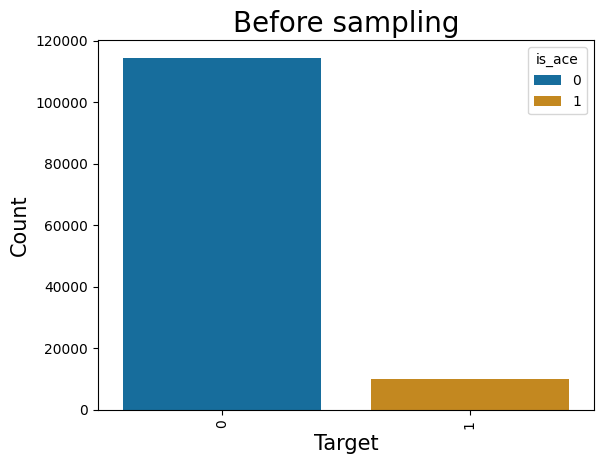

In [8]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("Before sampling", fontsize=20)
plt.show()

In [9]:
# Random oversampling to make the majority and minority class even

rd_over_sample = RandomOverSampler()
X_train, y_train = rd_over_sample.fit_resample(X_train, y_train)

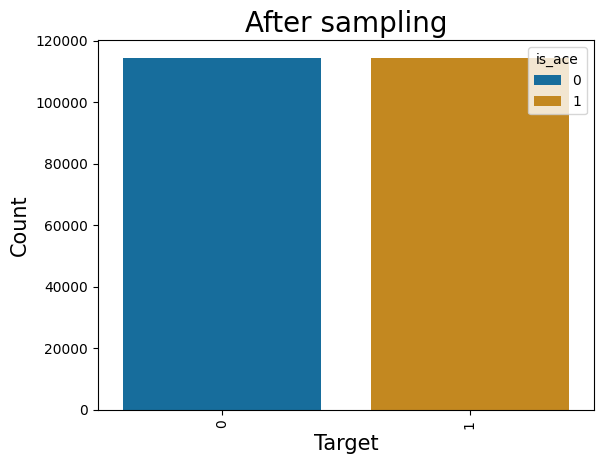

In [10]:
sns.countplot(data=pd.DataFrame(y_train), x="is_ace", hue="is_ace")
plt.xlabel("Target", fontsize=15)
plt.xticks(rotation=90)
plt.ylabel("Count", fontsize=15)
plt.title("After sampling", fontsize=20)
plt.show()

# Models

In [21]:
def scoring():
    """A function to print scores and save them in lists."""

    print("-----Test Data Accuracy----")
    a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_test.to_numpy(), y_pred), 4)
    print("F1 score:", f_1)
    accuracy_test.append(a_s)
    F1score_test.append(f_1)

    print("\n-----Train Data Accuracy----")
    a_s = round(accuracy_score(y_train.to_numpy(), y_pred_train), 4)
    print("Accuracy score:", a_s)
    f_1 = round(f1_score(y_train.to_numpy(), y_pred_train), 4)
    print("F1 score:", f_1)
    accuracy_train.append(a_s)
    F1score_train.append(f_1)

In [11]:
# Saving model scores in list for final evaluation
accuracy_test = []
accuracy_train = []
F1score_test = []
F1score_train = []

## Random Forest Classifer

In [17]:
# rfc = RandomForestClassifier(random_state=42, max_depth=10)

# # Training Model
# rfc.fit(X_train, y_train)
# # Save model
# joblib.dump(rfc, "model.joblib")

['model.joblib']

In [18]:
# Load model
saved_model = joblib.load("model.joblib")
# Predict
y_pred = saved_model.predict(X_test)
y_pred_train = saved_model.predict(X_train)

scoring()